In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]
y = data_file["labels"]
y[y == "healthy"] = 0
y[y == "unhealthy"] = 1
y = y.astype(np.float32)

Removing trolls, shreks and duplicates


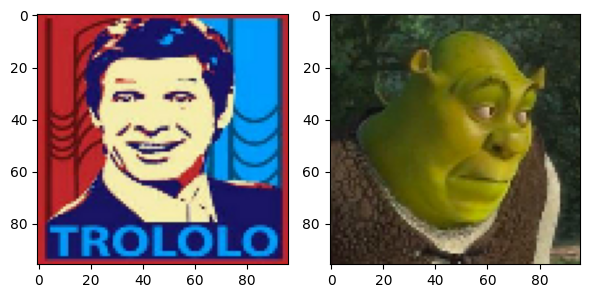

In [5]:
print("Removing trolls, shreks and duplicates")
initialDataN = data.shape[0]

troll = data[338]
shrek = data[58]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(troll / 255)
axes[1].imshow(shrek / 255)
plt.tight_layout()
plt.show()

In [6]:
mask = []
for i in range(data.shape[0]):
    if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
        mask.append(False)
    else:
        mask.append(True)
data = data[mask]
y = y[mask]

In [7]:
data, indexes = np.unique(data, axis=0, return_index=True)
y = y[indexes]

print("Removed Images: " + str(initialDataN - data.shape[0]))

Removed Images: 350


In [8]:
y = tfk.utils.to_categorical(y, num_classes=2)

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, y, random_state=seed, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

In [10]:
model = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [11]:
model.trainable = False

data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomRotation(0.1),
])

inputs = tfk.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
x = scale_layer(x)

x = model(x, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)

output = tfkl.Dense(2, activation="softmax")(x)
tl_model = tfk.Model(inputs, output)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [12]:
# Train the model
tl_history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 30,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/30
194/194 [==============================] - 9s 25ms/step - loss: 0.6350 - accuracy: 0.7020 - val_loss: 0.4650 - val_accuracy: 0.7822
Epoch 2/30
194/194 [==============================] - 3s 17ms/step - loss: 0.5126 - accuracy: 0.7674 - val_loss: 0.5077 - val_accuracy: 0.7668
Epoch 3/30
194/194 [==============================] - 3s 17ms/step - loss: 0.4739 - accuracy: 0.7812 - val_loss: 0.4779 - val_accuracy: 0.7809
Epoch 4/30
194/194 [==============================] - 3s 17ms/step - loss: 0.4733 - accuracy: 0.7806 - val_loss: 0.4706 - val_accuracy: 0.7848
Epoch 5/30
194/194 [==============================] - 3s 17ms/step - loss: 0.4525 - accuracy: 0.7996 - val_loss: 0.4358 - val_accuracy: 0.8003
Epoch 6/30
194/194 [==============================] - 3s 17ms/step - loss: 0.4430 - accuracy: 0.7883 - val_loss: 0.4931 - val_accuracy: 0.7758
Epoch 7/30
194/194 [==============================] - 3s 17ms/step - loss: 0.4656 - accuracy: 0.7845 - val_loss: 0.4701 - val_accuracy: 0.7912

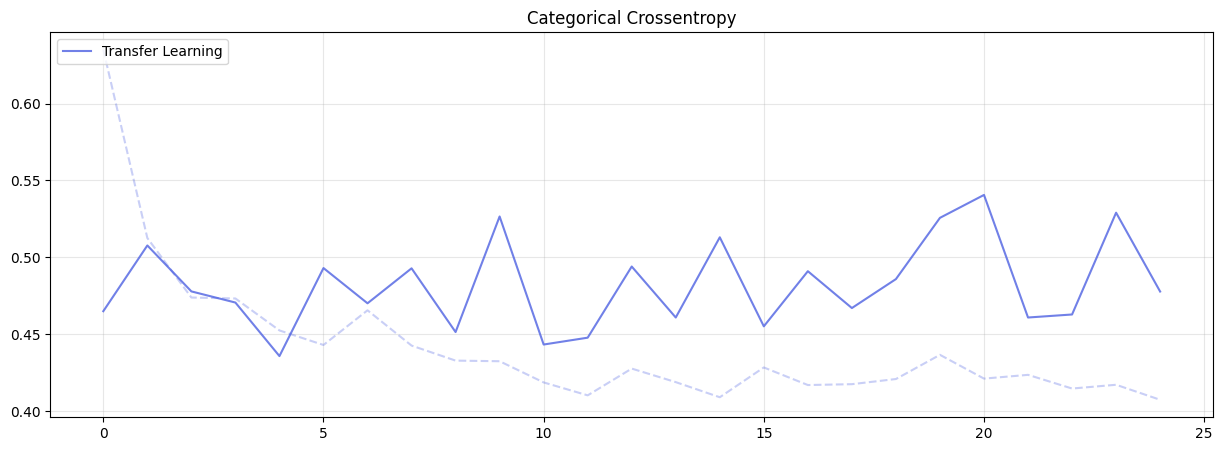

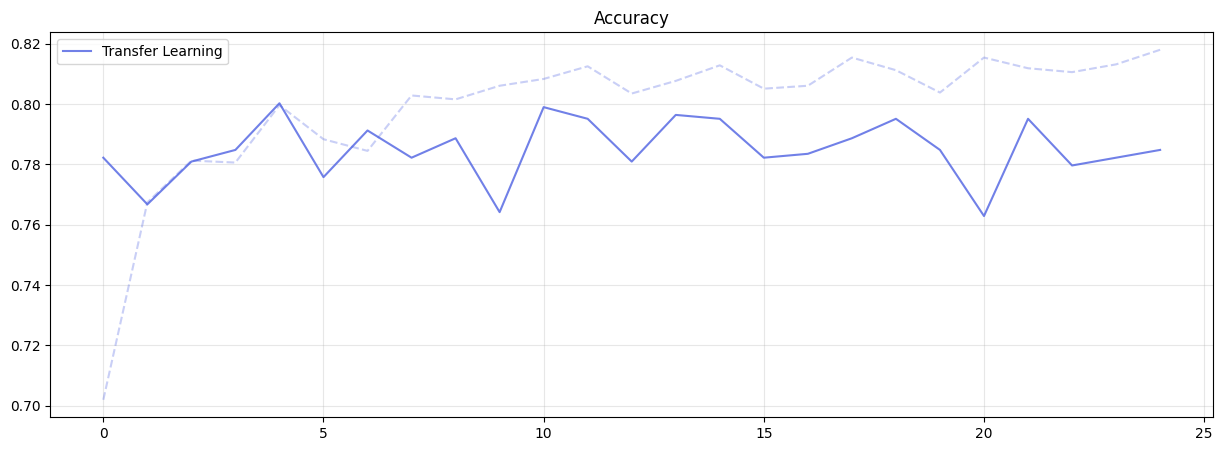

In [13]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [14]:
# Save the best model
tl_model.save('MobileTransferLearning_AUG')
del tl_model

In [15]:
ft_model = tf.keras.models.load_model('MobileTransferLearning_AUG')

In [16]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [17]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [18]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [19]:
# Train the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
194/194 [==============================] - 10s 28ms/step - loss: 0.4199 - accuracy: 0.8064 - val_loss: 0.4459 - val_accuracy: 0.7990
Epoch 2/100
194/194 [==============================] - 4s 23ms/step - loss: 0.3906 - accuracy: 0.8241 - val_loss: 0.4267 - val_accuracy: 0.8144
Epoch 3/100
194/194 [==============================] - 4s 23ms/step - loss: 0.3715 - accuracy: 0.8344 - val_loss: 0.4480 - val_accuracy: 0.8080
Epoch 4/100
194/194 [==============================] - 4s 23ms/step - loss: 0.3664 - accuracy: 0.8470 - val_loss: 0.4382 - val_accuracy: 0.8003
Epoch 5/100
194/194 [==============================] - 4s 22ms/step - loss: 0.3484 - accuracy: 0.8476 - val_loss: 0.4274 - val_accuracy: 0.8131
Epoch 6/100
194/194 [==============================] - 4s 23ms/step - loss: 0.3406 - accuracy: 0.8483 - val_loss: 0.4215 - val_accuracy: 0.8222
Epoch 7/100
194/194 [==============================] - 4s 23ms/step - loss: 0.3372 - accuracy: 0.8573 - val_loss: 0.4240 - val_accuracy

In [20]:
# Save the best model
ft_model.save('MobileFineTuning_AUG')
del ft_model

: 